In [3]:
import util
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import SGD
from keras.layers import Dropout
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler
from keras.callbacks import History
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping

from scipy.stats import reciprocal

In [4]:
filename = "../data/train_cleaned_1.csv"

data = util.load(filename)

x_train, y_train = data[0]
x_valid, y_valid = data[1]
x_test, y_test = data[2]

x_train_valid = np.concatenate((x_train, x_valid), axis=0)
y_train_valid = np.concatenate((y_train, y_valid), axis=0)

Epoch 1/1000
569/569 [==============================] - 2s 2ms/step - loss: 2.8234 - accuracy: 0.5784 - val_loss: 0.8286 - val_accuracy: 0.6901
Epoch 2/1000
569/569 [==============================] - 1s 1ms/step - loss: 0.7945 - accuracy: 0.6474 - val_loss: 0.6618 - val_accuracy: 0.6831
Epoch 3/1000
569/569 [==============================] - 1s 1ms/step - loss: 0.6504 - accuracy: 0.6987 - val_loss: 0.6181 - val_accuracy: 0.7042
Epoch 4/1000
569/569 [==============================] - 1s 1ms/step - loss: 0.6376 - accuracy: 0.6738 - val_loss: 0.5963 - val_accuracy: 0.7113
Epoch 5/1000
569/569 [==============================] - 1s 1ms/step - loss: 0.5803 - accuracy: 0.7349 - val_loss: 0.5994 - val_accuracy: 0.7254
Epoch 6/1000
569/569 [==============================] - 1s 1ms/step - loss: 0.5561 - accuracy: 0.7674 - val_loss: 0.5395 - val_accuracy: 0.7676
Epoch 7/1000
569/569 [==============================] - 1s 1ms/step - loss: 0.5092 - accuracy: 0.8220 - val_loss: 0.5453 - val_accuracy:

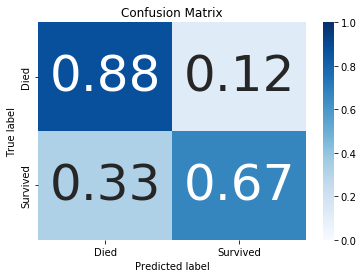

In [5]:
model = Sequential()
model.add(Dense(24, input_dim=x_train.shape[1], activation='tanh'))
model.add(Dense(16, activation='tanh',kernel_regularizer=l2(0.2), bias_regularizer=l2(0.01)))
model.add(Dense(8, activation='tanh',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.001)))
model.add(Dense(1, activation='sigmoid'))

# compile the keras model
opt = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# fit the keras model on the dataset
lr_model_history = model.fit(x_train, y_train, epochs=1000, batch_size=1, validation_data=(x_valid, y_valid))

# evaluate the keras model
_, accuracy = model.evaluate(x_valid, y_valid)
print('Accuracy: %.2f' % (accuracy*100))

y_pred = (model.predict(x_valid).flatten() > 0.5).astype(int)
cm = confusion_matrix(y_valid, y_pred)
util.plot_confusion_matrix(cm)

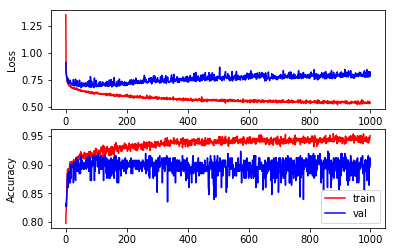

In [6]:
plt.subplot(2, 1, 1)
plt.plot(np.sqrt(lr_model_history.history['loss']), 'r', label='train')
plt.plot(np.sqrt(lr_model_history.history['val_loss']), 'b' ,label='val')
plt.ylabel("Loss")

plt.subplot(2, 1, 2)
plt.plot(np.sqrt(lr_model_history.history['accuracy']), 'r', label='train')
plt.plot(np.sqrt(lr_model_history.history['val_accuracy']), 'b' ,label='val')
plt.ylabel("Accuracy")

plt.legend()

# Optimizing the hyperparameters for neural net model

Trying to experiment with tweaking the hyperparameters in order to improve the model

In [5]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3):
    model = Sequential()
    model.add(Dense(24, input_dim=x_train.shape[1], activation='tanh'))
    for _ in range(n_hidden):
        model.add(Dense(n_neurons, activation="tanh"))
    model.add(Dense(1, activation="sigmoid"))
    opt = Adam(learning_rate=learning_rate)
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
    return model

In [6]:
model = KerasClassifier(build_model)
param_grid = {
    "n_hidden": [1, 2, 3, 4],
    "n_neurons": [4, 8, 16, 24],
    "learning_rate": [0.05, 0.01, 0.005, 0.001]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

18/18 [==============================] - 0s 1ms/step - loss: 0.6567 - accuracy: 0.5693
Best: 0.701273 using {'learning_rate': 0.005, 'n_hidden': 4, 'n_neurons': 24}
0.643239 (0.042410) with: {'learning_rate': 0.05, 'n_hidden': 1, 'n_neurons': 4}
0.622186 (0.036795) with: {'learning_rate': 0.05, 'n_hidden': 1, 'n_neurons': 8}
0.639854 (0.054776) with: {'learning_rate': 0.05, 'n_hidden': 1, 'n_neurons': 16}
0.639854 (0.050993) with: {'learning_rate': 0.05, 'n_hidden': 1, 'n_neurons': 24}
0.636330 (0.048423) with: {'learning_rate': 0.05, 'n_hidden': 2, 'n_neurons': 4}
0.652135 (0.041694) with: {'learning_rate': 0.05, 'n_hidden': 2, 'n_neurons': 8}
0.652166 (0.046443) with: {'learning_rate': 0.05, 'n_hidden': 2, 'n_neurons': 16}
0.646872 (0.061306) with: {'learning_rate': 0.05, 'n_hidden': 2, 'n_neurons': 24}
0.622186 (0.060006) with: {'learning_rate': 0.05, 'n_hidden': 3, 'n_neurons': 4}
0.659106 (0.050011) with: {'learning_rate': 0.05, 'n_hidden': 3, 'n_neurons': 8}
0.639839 (0.051657) w

In [7]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.701273 using {'learning_rate': 0.005, 'n_hidden': 4, 'n_neurons': 24}


The above results seem worse than what we have got with manual model setup

Could be worth tweaking the search grid parameters to improve the results?